In [1]:
from bd2dst3pi.definitions import years, magnets
from bd2dst3pi.locations import loc
from copy import deepcopy
import pandas as pd

import sys
sys.path.append(loc.SCRIPTS)
from load_save_data import load_data, save_dataframe
from plot.tool import save_file
import plot.histogram as h
import BDT.BDT as BDT

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Roman']})
rc('text', usetex=True)

Welcome to JupyROOT 6.22/02


#  `adaboost_without_P_with_cut_deltaM_highB0M`
#  `gradient_without_P_with_cut_deltaM_highB0M`
- Samples:
    - background sample = high `B0_M` `common_M` sample: `5355. < B0_M < 5570`
    
- For all the samples, `143. < Delta_M < 148.`
- Sample weight balancing (in `BDT.py`)
- Use `AdaboostClassifier` or `XGBClassifier`

In [2]:
low_bkg = 5355.
high_bkg = 5570.

## Training variables

In [3]:
variables = []

# for particle in ['B0']:
#     variables.append(f"{particle}_M")

for particle in ['B0', 'Dst', 'tau_pion0', 'tau_pion1', 'tau_pion2']:
    #variables.append(f"{particle}_P")
    variables.append(f"{particle}_PT")

for particle in ['B0', 'Dst', 'tau']:
    variables.append(f"{particle}_ENDVERTEX_CHI2")

        
for particle in ['tau_pion0', 'tau_pion1', 'tau_pion2']:
    variables.append(f"{particle}_TRACK_CHI2NDOF")

add_variables = ['B0_M', 'tau_M', 'Dst_M', 'D0_M']

## Load data

In [4]:
low_bkg = 5355
high_bkg = 5550

In [5]:
name_BDT = 'adaboost_without_P_cutDeltaM_highB0M'
#name_BDT = 'gradient_without_P_cutDeltaM_highB0M'

### Full datasets

In [36]:
df = {}
print("retrieve MC")
df['MC'] = load_data(years,magnets, type_data = 'MC',vars = add_variables + variables) # already cut on DeltaM
print("retrieve common data")
df['common'] = load_data(years, magnets, type_data = 'common', vars = add_variables + variables, cut_DeltaM=True)
add_variables.append("Delta_M")
# Remove the variables that were created to cut on DeltaM

retrieve MC
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//norm/Bd_Dst3pi/Bd_Dst3pi_11266018_2015_up_Sim09e-ReDecay01.root
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//norm/Bd_Dst3pi/Bd_Dst3pi_11266018_2015_down_Sim09e-ReDecay01.root
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//norm/Bd_Dst3pi/Bd_Dst3pi_11266018_2016_up_Sim09e-ReDecay01.root
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//norm/Bd_Dst3pi/Bd_Dst3pi_11266018_2016_down_Sim09e-ReDecay01.root
retrieve common data
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//common/data/data_90000000_2015_up.root
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//common/data/data_90000000_2015_down.root
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//common/data/data_90000000_2016_up.root
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//common/data/data_90000000_2016_down.root
cut on DeltaM has removed 425088 over 935261 events


### Remove some variables

The variables `Dst_M`, `D0_M` and `DeltaM`, created by the cut on `DeltaM`, are not trained with and need to be removed from the datasample.

### Splitting of the `common` data

We randomly split the `common` data into two samples of same size

In [44]:
df['common1'] = df['common'].sample(frac=0.5, random_state=10)
df['common2'] = df['common'].drop(df['common1'].index,0).sample(frac=1.)

Some checks that they have the same size and are randomly separated

In [45]:
print(len(df['common1']), len(df['common2']))

255086 255087


/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/B0_M_data_1_data_2.pdf
/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/B0_M_data_1_data_2.pdf


(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='$m$($D^{*}3\\pi$) [MeV/$c^2$]', ylabel='Proportion of candidates / (4 MeV/$c^2$)'>)

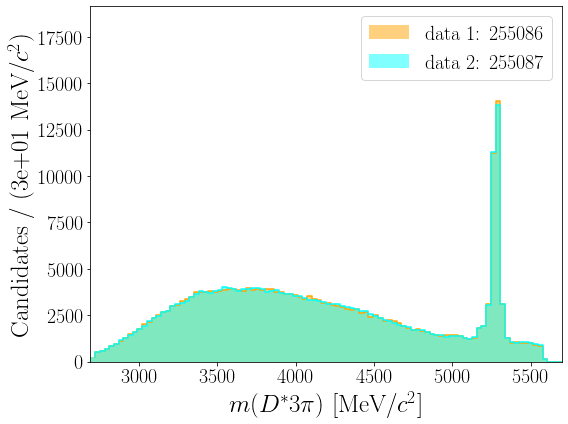

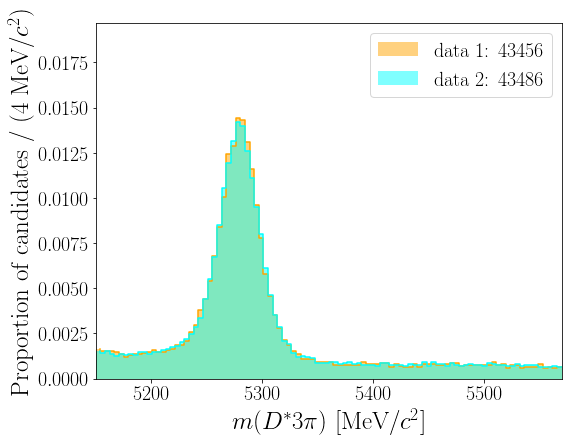

In [46]:
h.plot_hist_particle({'data 1': df['common1'], 'data 2':df['common2']},'B0_M',
              n_bins = 100, mode_hist = True, colors=['orange', 'cyan'], density=False)
low=5150
high=5570
h.plot_hist_particle({'data 1': df['common1'], 'data 2':df['common2']},'B0_M',
              n_bins = 100, mode_hist = True, colors=['orange', 'cyan'],
                    low=low, high=high)

### Background samples

In [47]:
df['bkg1'] = df['common1'].query(f'B0_M > {low_bkg} and B0_M <{high_bkg}')
df['bkg2'] = df['common2'].query(f'B0_M > {low_bkg} and B0_M <{high_bkg}')
print('bgk1: ', len(df['bkg1']), 'events')
print('bgk2: ', len(df['bkg2']), 'events')

bgk1:  6495 events
bgk2:  6660 events


/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/B0_M_bkg_1_bkg_2.pdf


(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='$m$($D^{*}3\\pi$) [MeV/$c^2$]', ylabel='Candidates / (2 MeV/$c^2$)'>)

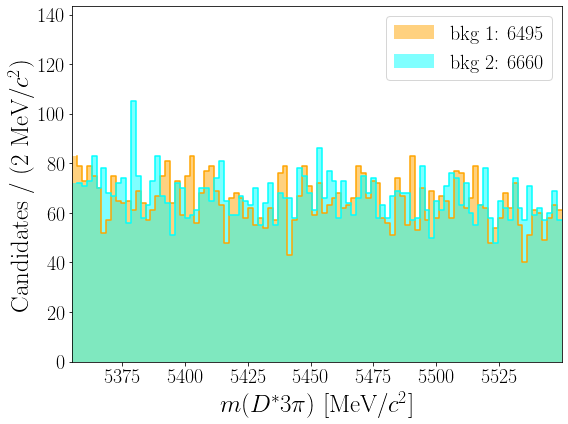

In [48]:
h.plot_hist_particle({'bkg 1': df['bkg1'], 'bkg 2':df['bkg2']},'B0_M',
              n_bins = 100, mode_hist = True, colors=['orange', 'cyan'], density=False)

In [49]:
for data in 'bkg1', 'bkg2', 'MC':
    for add_var in add_variables+['index']:
        try:
            df[data] = df[data].drop(add_var, 1)
        except KeyError:
            pass

In [50]:
for data in 'common1', 'common2': # with training variables
    df[data+'_t'] = deepcopy(df[data])
    for add_var in add_variables+['index']:
        df[data+'_t'] = df[data+'_t'].drop(add_var, 1)

## Analysis before training

### Concatenation

In [51]:
X1, y1, df1 = BDT.concatenate(df['MC'], df['bkg1'])
X2, y2, df2 = BDT.concatenate(df['MC'], df['bkg2'])

### 1D histograms

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/BDT/adaboost_without_P_cutDeltaM_highB0M1/1D_hist_adaboost_without_P_cutDeltaM_highB0M1.pdf
/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/BDT/adaboost_without_P_cutDeltaM_highB0M2/1D_hist_adaboost_without_P_cutDeltaM_highB0M2.pdf


(<Figure size 2880x1800 with 12 Axes>,
 array([[<AxesSubplot:title={'center':'B0_PT'}>,
         <AxesSubplot:title={'center':'Dst_PT'}>,
         <AxesSubplot:title={'center':'tau_pion0_PT'}>],
        [<AxesSubplot:title={'center':'tau_pion1_PT'}>,
         <AxesSubplot:title={'center':'tau_pion2_PT'}>,
         <AxesSubplot:title={'center':'B0_ENDVERTEX_CHI2'}>],
        [<AxesSubplot:title={'center':'Dst_ENDVERTEX_CHI2'}>,
         <AxesSubplot:title={'center':'tau_ENDVERTEX_CHI2'}>,
         <AxesSubplot:title={'center':'tau_pion0_TRACK_CHI2NDOF'}>],
        [<AxesSubplot:title={'center':'tau_pion1_TRACK_CHI2NDOF'}>,
         <AxesSubplot:title={'center':'tau_pion2_TRACK_CHI2NDOF'}>,
         <AxesSubplot:>]], dtype=object))

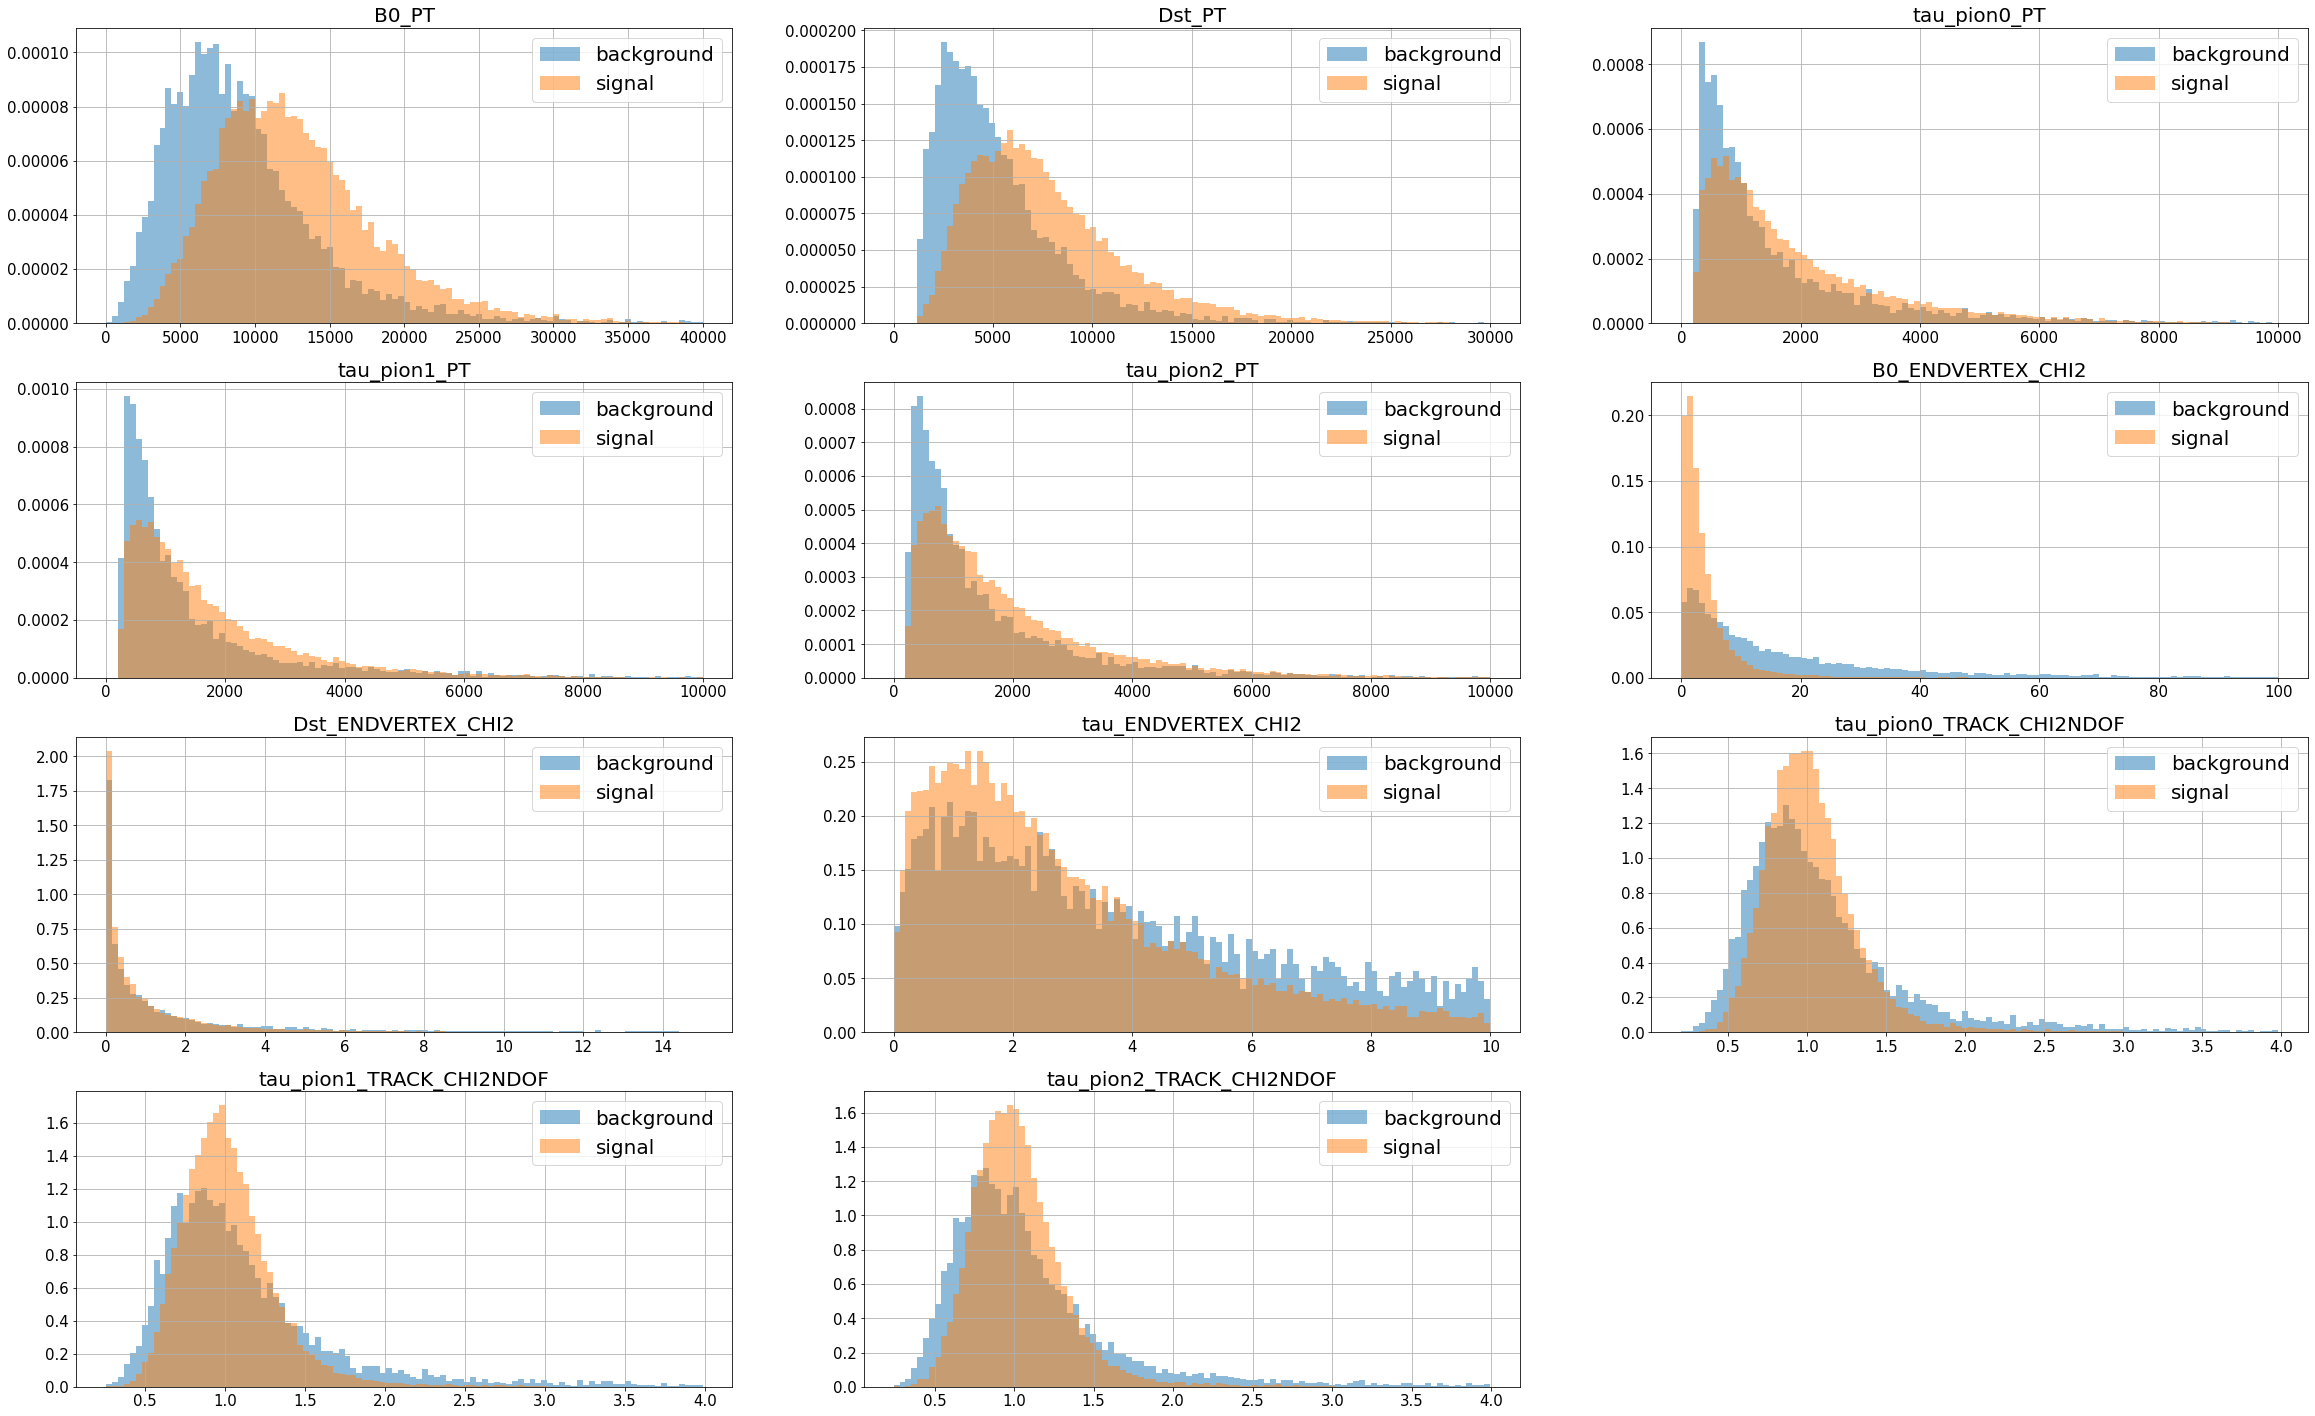

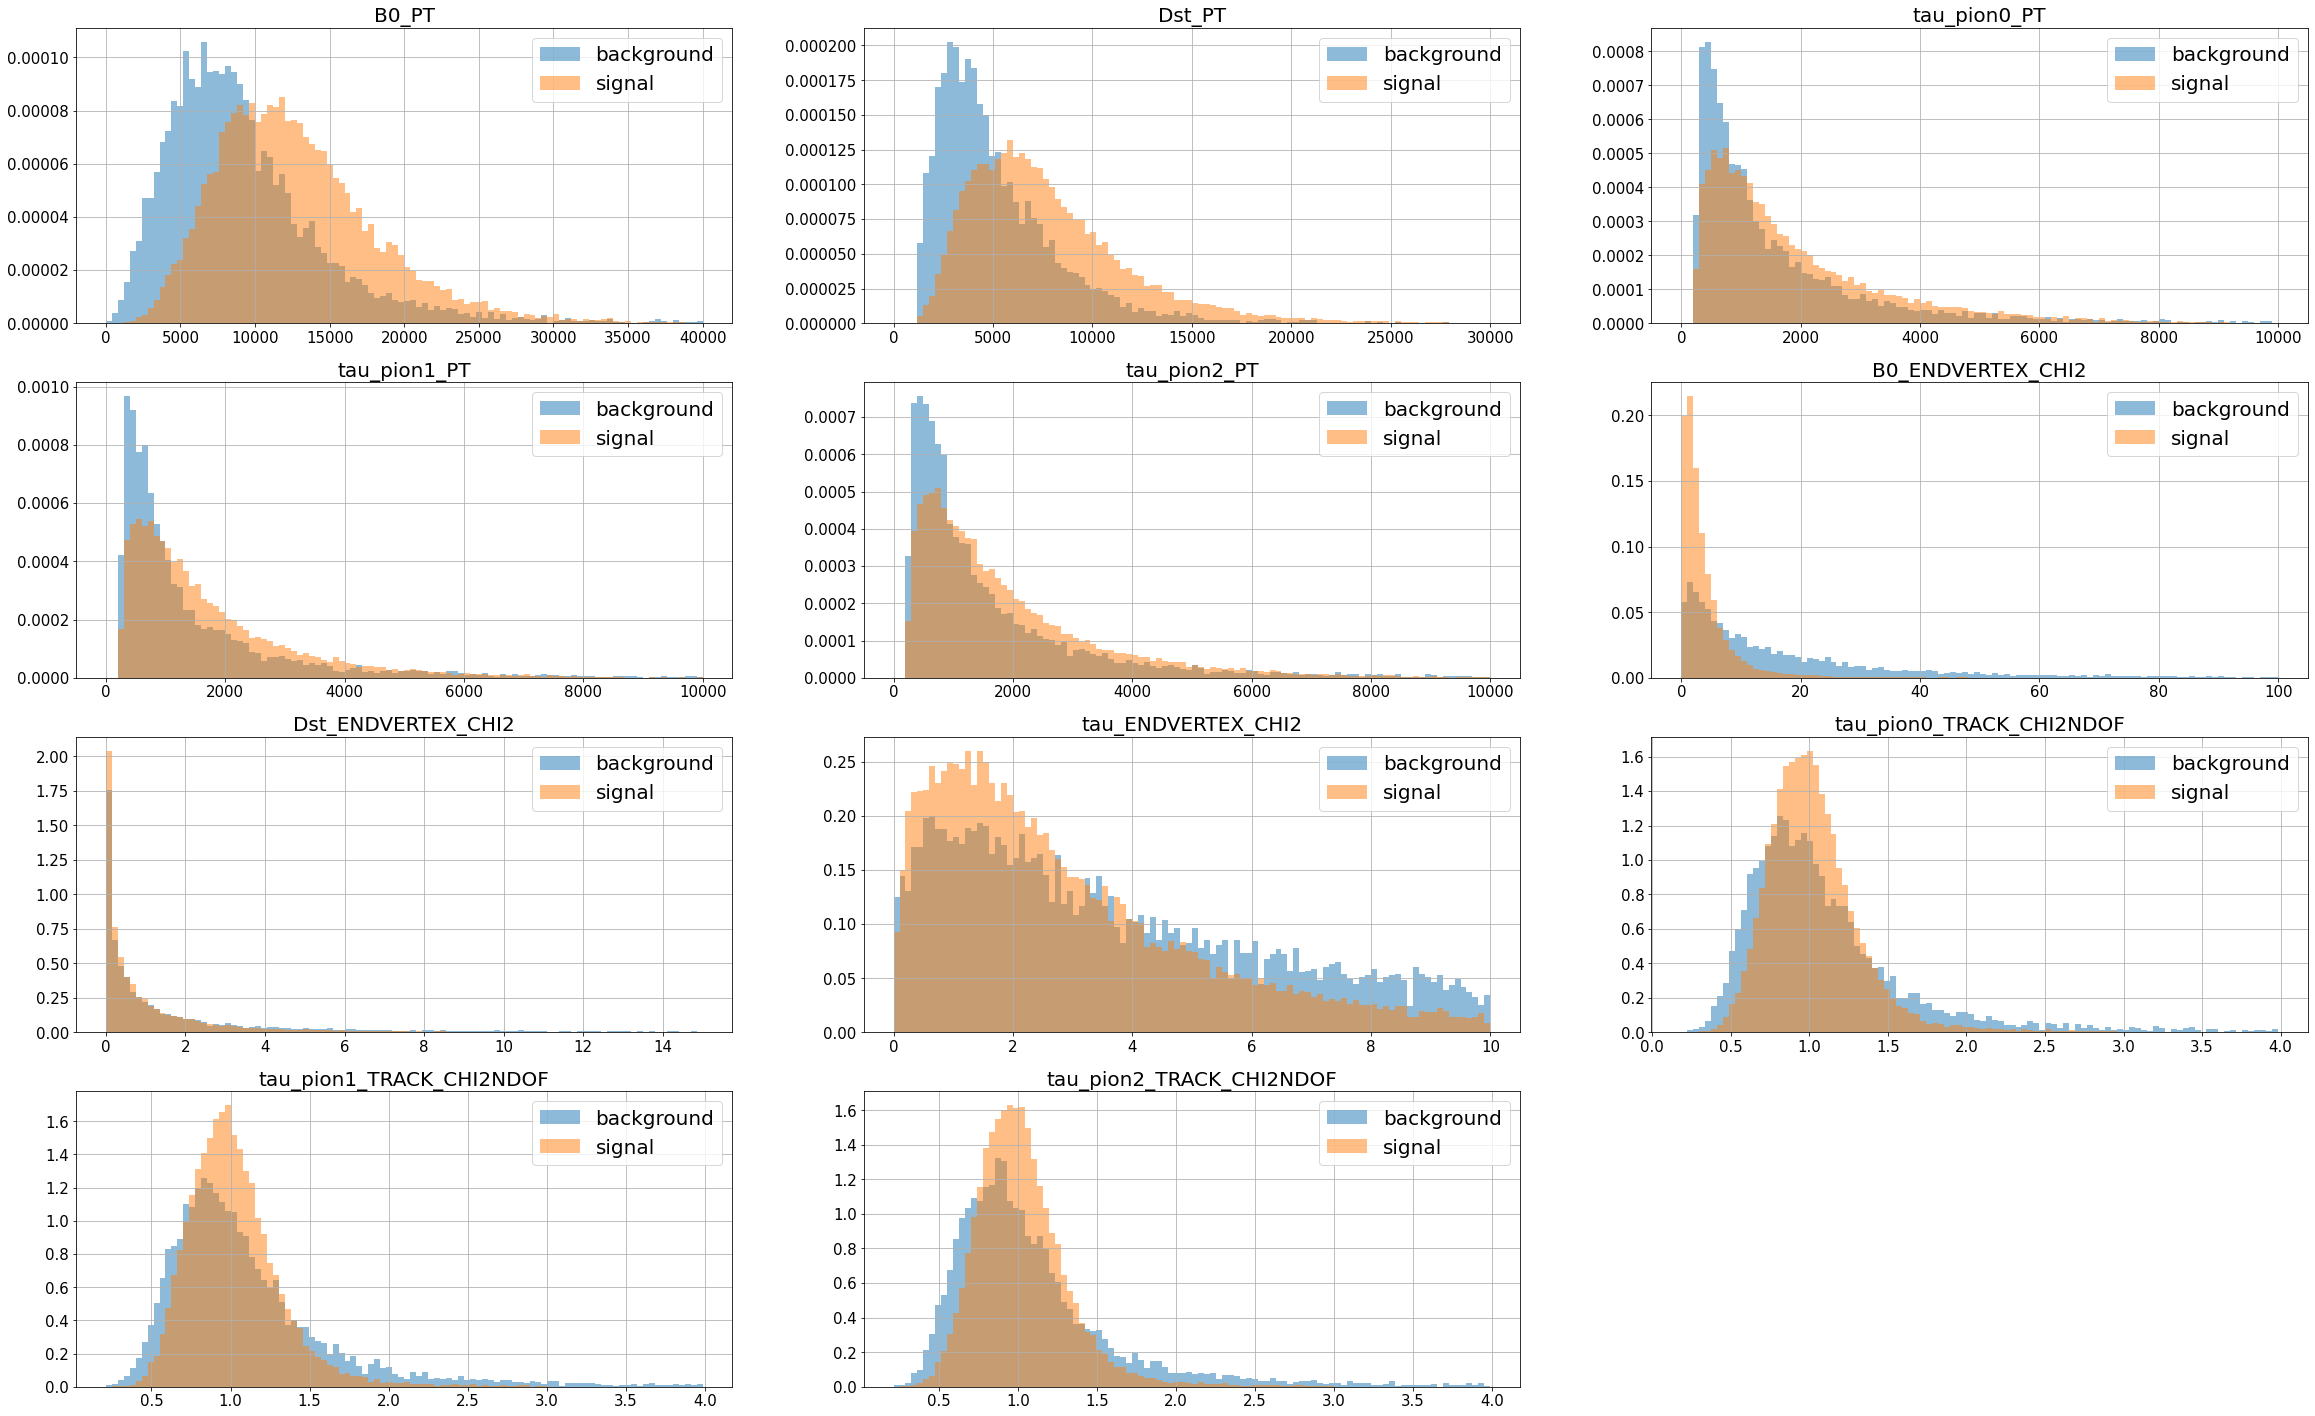

In [52]:
BDT.signal_background(df1[df1.y<0.5], df1[df1.y>0.5],
                  column=variables,
                  range_column=[
                      [0,40000],
                      [0,30000],
                      [0,10000],
                      [0,1e4],
                      [0,1e4],
                      [0,100],
                      [0,15],
                      None,None,None,None
                  ],
                  bins=100, figsize = (40,25), name_file = name_BDT+'1', name_folder = name_BDT+'1')
BDT.signal_background(df2[df2.y<0.5], df2[df2.y>0.5],
                  column=variables,
                  range_column=[
                      [0,40000],
                      [0,30000],
                      [0,10000],
                      [0,1e4],
                      [0,1e4],
                      [0,100],
                      [0,15],
                      None,None,None,None
                  ],
                  bins=100, figsize = (40,25), name_file = name_BDT+'2', name_folder = name_BDT+'2')

### Correlation matrix

In [53]:
bg1,sig1 = BDT.bg_sig(y1)
bg2,sig2 = BDT.bg_sig(y2)

Background
/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/BDT/adaboost_without_P_cutDeltaM_highB0M1/corr_matrix_adaboost_without_P_cutDeltaM_highB0M_background1.pdf
/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/BDT/adaboost_without_P_cutDeltaM_highB0M2/corr_matrix_adaboost_without_P_cutDeltaM_highB0M_background2.pdf
Signal
/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/BDT/adaboost_without_P_cutDeltaM_highB0M1/corr_matrix_adaboost_without_P_cutDeltaM_highB0M_signal1.pdf
/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/BDT/adaboost_without_P_cutDeltaM_highB0M2/corr_matrix_adaboost_without_P_cutDeltaM_highB0M_signal2.pdf


(<Figure size 864x720 with 2 Axes>,
 <AxesSubplot:title={'center':'Correlations - adaboost_without_P_cutDeltaM_highB0M_signal2'}>)

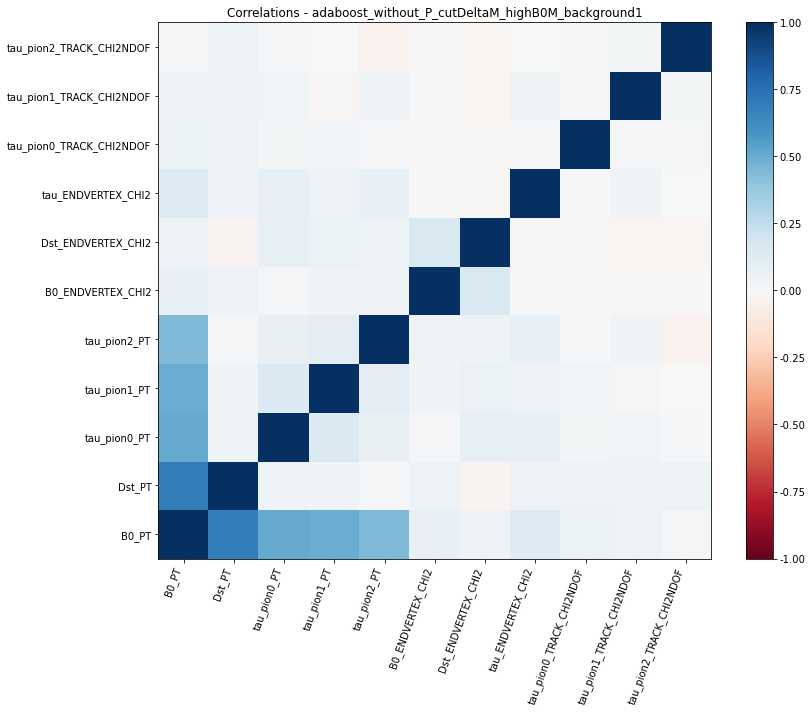

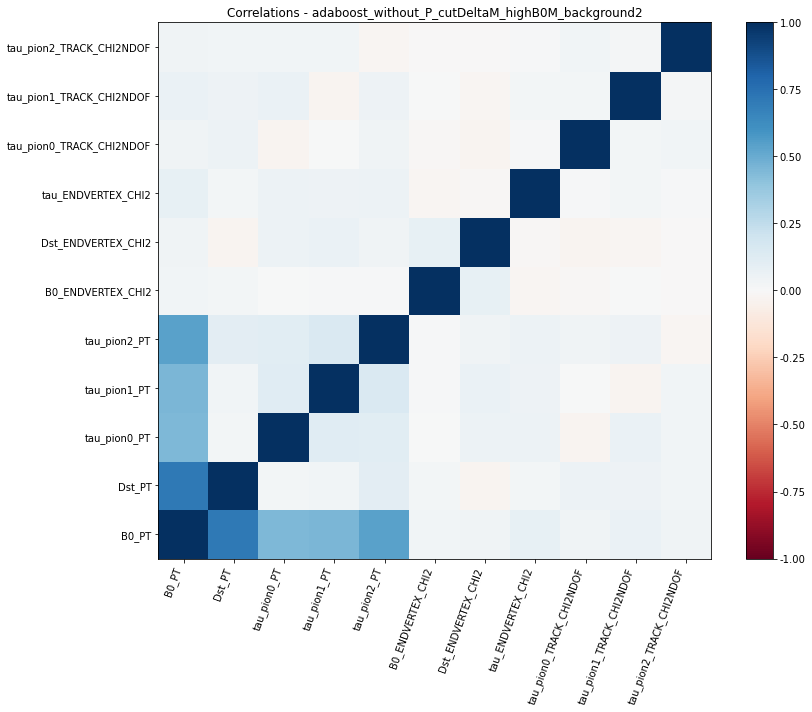

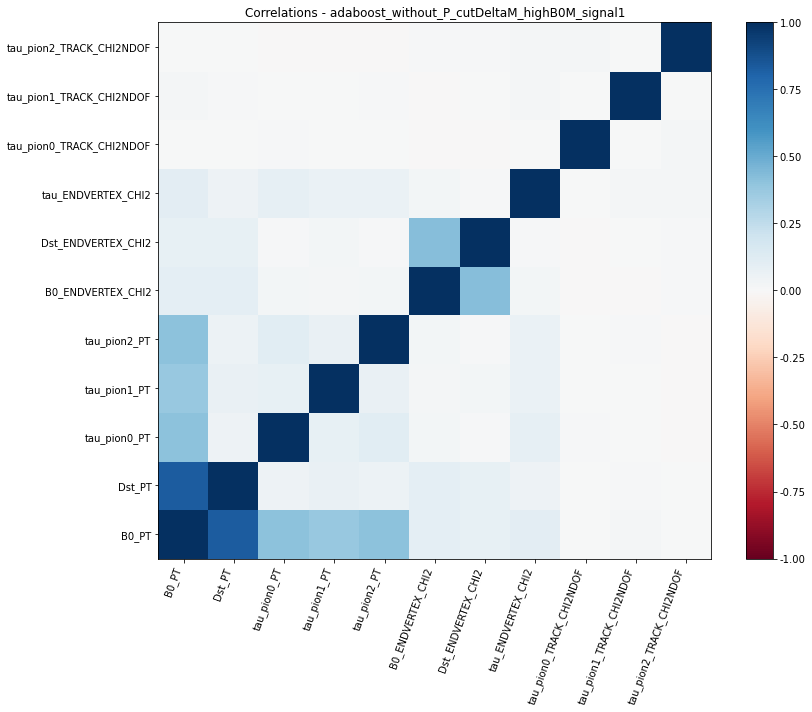

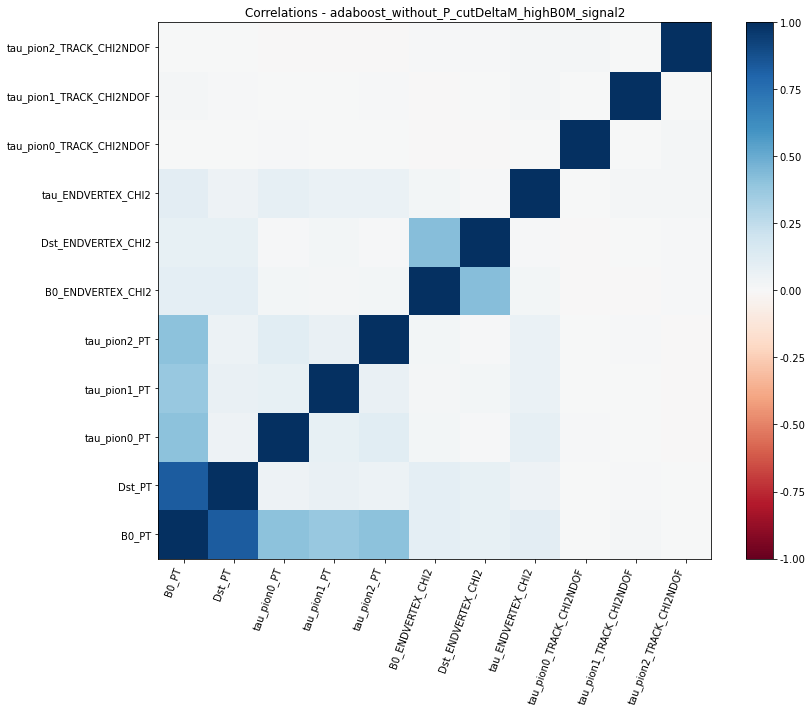

In [54]:
print("Background")
BDT.correlations(df1[bg1].drop('y', 1),name_file= name_BDT+'_background1', name_folder = name_BDT+'1') # Drop the column(->1) 'y'
BDT.correlations(df2[bg2].drop('y', 1),name_file= name_BDT+'_background2', name_folder = name_BDT+'2') # Drop the column(->1) 'y'

print("Signal")
BDT.correlations(df1[sig1].drop('y', 1),name_file= name_BDT+'_signal1', name_folder = name_BDT+'1')
BDT.correlations(df2[sig2].drop('y', 1),name_file= name_BDT+'_signal2', name_folder = name_BDT+'2')

## Training

In [55]:
X_train1, y_train1, X_test1, y_test1, bdt1 = BDT.BDT(X1, y1)

In [56]:
X_train2, y_train2, X_test2, y_test2, bdt2 = BDT.BDT(X2, y2)

## Testing

### Report

In [57]:
BDT.classification_report_print(X_test1, y_test1, bdt1,name_BDT+'1')
BDT.classification_report_print(X_test2, y_test2, bdt2,name_BDT+'2')

              precision    recall  f1-score   support

  background       0.65      0.81      0.72      3282
      signal       0.94      0.88      0.91     11828

    accuracy                           0.86     15110
   macro avg       0.80      0.84      0.81     15110
weighted avg       0.88      0.86      0.87     15110

Area under ROC curve: 0.9189
              precision    recall  f1-score   support

  background       0.64      0.83      0.72      3322
      signal       0.95      0.87      0.91     11870

    accuracy                           0.86     15192
   macro avg       0.79      0.85      0.81     15192
weighted avg       0.88      0.86      0.87     15192

Area under ROC curve: 0.9223


### Roc curve

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/BDT/adaboost_without_P_cutDeltaM_highB0M1/ROC_adaboost_without_P_cutDeltaM_highB0M1.pdf
/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/BDT/adaboost_without_P_cutDeltaM_highB0M2/ROC_adaboost_without_P_cutDeltaM_highB0M2.pdf


(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:title={'center':'Receiver operating characteristic - adaboost_without_P_cutDeltaM_highB0M2'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>)

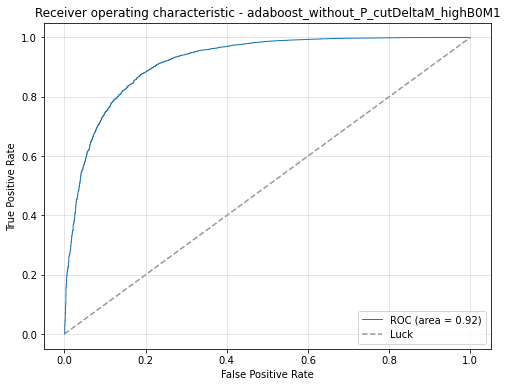

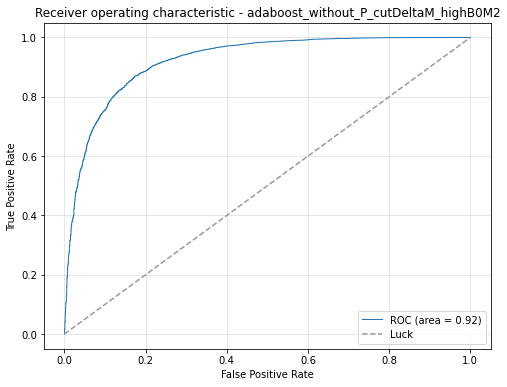

In [58]:
BDT.plot_roc(X_test1, y_test1, bdt1, name_BDT+'1', name_folder = name_BDT+'1')
BDT.plot_roc(X_test2, y_test2, bdt2, name_BDT+'2', name_folder = name_BDT+'2')

### Overtraining check

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/BDT/adaboost_without_P_cutDeltaM_highB0M1/overtraining_adaboost_without_P_cutDeltaM_highB0M1.pdf
/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/BDT/adaboost_without_P_cutDeltaM_highB0M2/overtraining_adaboost_without_P_cutDeltaM_highB0M2.pdf


(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='BDT output', ylabel='Arbitrary units'>)

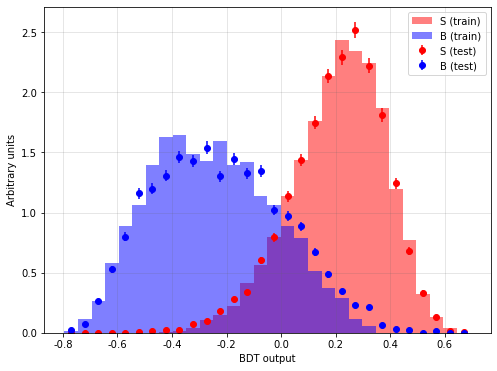

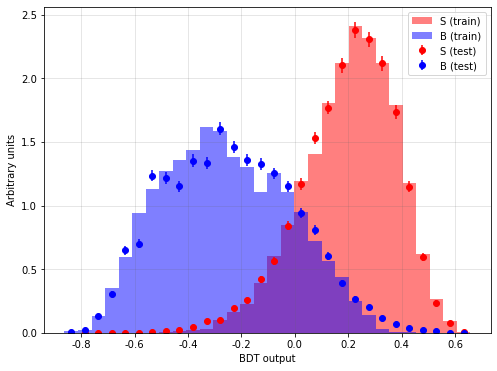

In [59]:
BDT.compare_train_test(bdt1, X_train1, y_train1, X_test1, y_test1, name_BDT = name_BDT+'1', name_folder = name_BDT+'1')
BDT.compare_train_test(bdt2, X_train2, y_train2, X_test2, y_test2, name_BDT = name_BDT+'2', name_folder = name_BDT+'2')

### Apply to the data

In [60]:
df['common1']['BDT'] = bdt2.decision_function(df['common1_t'])
df['common2']['BDT'] = bdt1.decision_function(df['common2_t'])

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/BDT_data_1_data_2.pdf


(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='BDT', ylabel='Proportion of candidates / (0.02)'>)

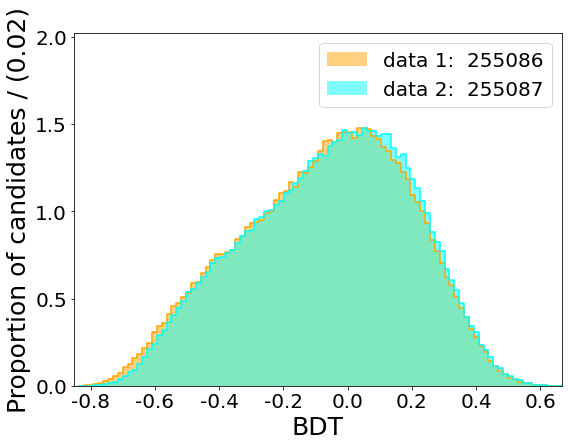

In [61]:
h.plot_hist_particle({'data 1': df['common1'], 'data 2':df['common2']},'BDT',
              n_bins = 100, mode_hist = True, colors=['orange', 'cyan'])

In [62]:
df['common_withBDT'] = pd.concat([df['common1'],df['common2']])
len(df['common_withBDT']) == len(df['common1']) + len(df['common2'])

True

In [63]:
df['common_withBDT']['B0_M']

317407    4645.231534
102526    5059.256269
159355    4624.568953
108701    3615.631065
431205    3548.815718
             ...     
332973    4250.858502
261155    3570.374490
122527    3550.678245
403087    4032.114706
362973    4987.556115
Name: B0_M, Length: 510173, dtype: float64

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/adaboost_without_P_cutDeltaM_highB0M/BDT_cut_on_B0_M.pdf


(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='$m$($D^{*}3\\pi$) [MeV/$c^2$]', ylabel='Candidates / (4 MeV/$c^2$)'>)

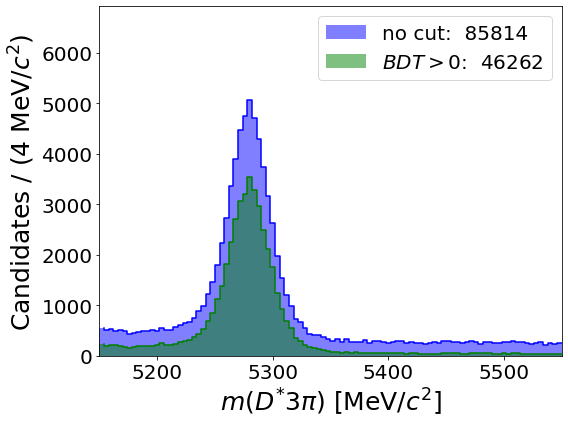

In [64]:
low = 5150.
high = 5550.

h.plot_hist_particle({'no cut':df['common_withBDT'], '$BDT>0$':df['common_withBDT'].query('BDT>0')},
          'B0_M', n_bins = 100,low = low,high=high,mode_hist=True, 
                       colors=['b', 'g', 'r'],
            name_file = 'BDT_cut_on_B0_M',name_folder = name_BDT, density=False)

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/adaboost_without_P_cutDeltaM_highB0M/BDTvsB0_M.pdf


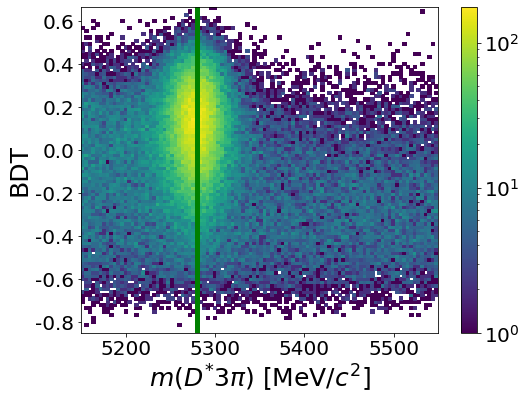

In [68]:
fig, ax = h.plot_hist2d_particle(df['common_withBDT'],['B0_M','BDT'], low=[low,None],high=[high,None],
            name_folder = name_BDT, log_scale = True, save_fig=False)
ax.axvline(x=5279.53, color='green', linewidth=5.)
save_file(fig, "BDTvsB0_M",name_BDT)

In [66]:
save_dataframe(df['common_withBDT'], f'common_{name_BDT}', 'DecayTree')

/afs/cern.ch/user/c/correian/bd2dst3pi/output/root//common_adaboost_without_P_cutDeltaM_highB0M.root
